In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:
import torch
import torch.backends.cudnn as cudnn
import random
import numpy as np

# seeds
seed = 88
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
cudnn.deterministic = True
cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
from torchvision.datasets import FGVCAircraft
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# remove copyright banner
class RemoveCopyrightBanner(object):
    def __call__(self, img):
        width, height = img.size
        return img.crop((0, 0, width, height - 20))

transform = transforms.Compose([
    RemoveCopyrightBanner(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the FGVC Aircraft dataset instance
train_dataset = FGVCAircraft(
    root='./data',
    split='trainval',              # Options: 'train', 'val', 'trainval', 'test'
    annotation_level='variant',    # Options: 'variant', 'family', 'manufacturer'
    transform=transform,
    download=True
)

# shuffle the train dataset and split into 20% val, 80% train
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])

# val_dataset = FGVCAircraft(
#     root='./data',
#     split='val',
#     annotation_level='variant',
#     transform=transform,
#     download=True
# )

test_dataset = FGVCAircraft(
    root='./data',
    split='test',
    annotation_level='variant',
    transform=transform,
    download=True
)

100%|██████████| 2.75G/2.75G [00:26<00:00, 104MB/s] 


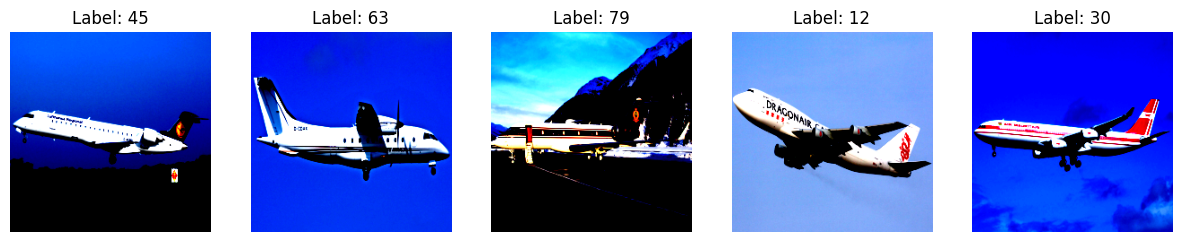

In [4]:
# function to show images
def show_images(train_dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = train_dataset[i]
        image = image.permute(1, 2, 0)  # convert from CxHxW to HxWxC
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

show_images(train_dataset, num_images=5)

# Create Dataset

In [5]:
from collections import defaultdict
import torch
from tqdm import tqdm

def group_task_indices(dataset, test='False'):
    """
    Task 0: 0-9, Task 1: 10-19, ..., Task 9: 90-99
    Output a dictionary where keys are task indices and values are lists of image indices.
    For example, task_dict[0] will contain indices of images with labels 0-9.
    """
    task_dict = defaultdict(list)
    for idx, (_, label) in tqdm(enumerate(dataset), total=len(dataset)):
        # for test, should have cumulative indices (all classes seen so far)
        if test:
          for i in range((label // 10), 10):
            task_dict[i].append(idx)
        else:
          task_dict[label // 10].append(idx)
    return task_dict

train_task_idxs = group_task_indices(train_dataset)
val_task_idxs = group_task_indices(val_dataset)
test_task_idxs = group_task_indices(test_dataset)

100%|██████████| 3333/3333 [00:45<00:00, 74.02it/s]


In [8]:
labels_dict = defaultdict(int)
for i in train_task_idxs[2]:
    _, label = train_dataset[i]
    labels_dict[label] += 1
print(labels_dict)

defaultdict(<class 'int'>, {12: 54, 14: 54, 19: 54, 24: 54, 27: 57, 7: 46, 3: 56, 26: 51, 11: 53, 6: 60, 16: 57, 29: 50, 22: 59, 17: 54, 21: 52, 25: 58, 10: 55, 8: 57, 20: 54, 2: 55, 9: 50, 15: 51, 28: 51, 13: 48, 23: 54, 1: 57, 0: 60, 4: 53, 18: 52, 5: 49})


## Training Code

In [23]:
def val_net(net_to_val, val_loader):
    net_to_val.eval()
    loss = 0

    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for img, label in tqdm(val_loader, desc="Validating"):

            # Get the input images and their corresponding labels
            img, label = img.cuda(), label.cuda()

            # Forward pass: Get predictions from the model
            outputs = net_to_val(img)

            # compute SmoothL1Losss
            loss += criterion(outputs, label)

        return loss / len(val_loader)

def train_net(max_epochs, freeze_epochs, net_to_train, opt, train_loader, val_loader, save_path=None):
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    # prepare the net for training
    net_to_train.cuda()

    # freeze backbone
    for param in net_to_train.parameters():
        param.requires_grad = False
    for param in net_to_train.fc.parameters():
        param.requires_grad = True

    # loop over the dataset multiple times
    for epoch in range(max_epochs):
        net_to_train.train()

        running_loss = 0.0

        # unfreeze all layers
        if epoch == freeze_epochs:
          for param in net_to_train.parameters():
              param.requires_grad = True
              # change optimizer learning rate
              opt.param_groups[0]['lr'] = 1e-4

        # train on batches of data
        for imgs, labels in tqdm(train_loader, unit='batch'):

            imgs, labels = imgs.cuda(), labels.cuda()

            # zero the parameter gradients
            opt.zero_grad()

            # prediction
            outputs = net_to_train(imgs)

            # compute the loss
            loss = criterion(outputs, labels)
            loss.backward()
            opt.step()

            # print loss statistics
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        val_losses.append(val_net(net_to_train, val_loader))
        print(f"Epoch {epoch + 1}, Training Loss: {avg_loss:.3f}, Validation Loss: {val_losses[-1]:.3f}")

        # save checkpoint
        if save_path:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': net_to_train.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': avg_loss,
            }, save_path)
            print(f"Checkpoint saved to {save_path}")

        # early stopping if validation loss increases for 2 consec epochs
        if len(val_losses) > 2 and val_losses[-1] > val_losses[-2] and val_losses[-2] > val_losses[-3]:
            print("Early stopping triggered")
            break

    print("finished training")
    return train_losses, val_losses

In [16]:
import torch.nn as nn
def modify_resnet_head(model, num_classes):
  """
  Modify the last fully connected layer of the ResNet model to match the number of classes.
  """

  old_fc = model.fc
  old_num_classes = old_fc.out_features
  num_ftrs = old_fc.in_features

  # Create the new head
  new_fc = nn.Linear(num_ftrs, num_classes).cuda()

  # Copy weights and biases from the old head
  if old_num_classes < num_classes:
    new_fc.weight.data[:old_num_classes, :] = old_fc.weight.data.clone().cuda()
    new_fc.bias.data[:old_num_classes] = old_fc.bias.data.clone().cuda()

  model.fc = new_fc
  return model

In [17]:
import torch

def get_test_accuracy(model, test_loader, num_classes):
    model.eval()
    correct_preds = 0
    total = 0
    correct_per_class = [0] * num_classes
    total_per_class = [0] * num_classes

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing", total=len(test_loader)):
            imgs, labels = imgs.cuda(), labels.cuda()
            output = model(imgs)
            preds = output.argmax(dim=1)

            correct_preds += (preds == labels).sum().item()
            total += labels.size(0)

            # Per-class stats
            for c in range(num_classes):
                correct_per_class[c] += ((preds == c) & (labels == c)).sum().item()
                total_per_class[c] += (labels == c).sum().item()

    overall_acc = correct_preds / total
    per_class_acc = [correct_per_class[c] / total_per_class[c] if total_per_class[c] > 0 else 0.0
                     for c in range(num_classes)]
    return overall_acc, per_class_acc


In [ ]:
from torch.utils.data import Subset
from torchvision import models
import torch.optim as optim

# Initialize the model
model = models.resnet18(pretrained=True)

# freeze all parameters except the last fc layer
for name, param in model.named_parameters():
    if name != 'fc.weight' and name != 'fc.bias':
        param.requires_grad = False

# test_loader = torch.utils.data.DataLoader(
#     test_dataset, batch_size=32, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
# )

for task in range(10):

    print(f"Training on task {task}...")

    model = modify_resnet_head(model, (task+1) * 10)
    model = model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=0.0015)

    train_loader = torch.utils.data.DataLoader(
        Subset(train_dataset, train_task_idxs[task]), batch_size=32, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=g
    )
    val_loader = torch.utils.data.DataLoader(
        Subset(val_dataset, val_task_idxs[task]), batch_size=32, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
    )

    test_loader = torch.utils.data.DataLoader(
        Subset(test_dataset, test_task_idxs[task]), batch_size=32, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
    )

    # Train the model on the current task
    train_losses, val_losses = train_net(25, 5, model, optimizer, train_loader, val_loader)

    # Evaluate the model on the test set
    overall_acc, per_class_acc = get_test_accuracy(model, test_loader, (task+1) * 10)
    print(f"Overall accuracy for task {task}: {overall_acc:.4f}")
    print(f"Per-class accuracy for task {task}: {per_class_acc}")

    # save to text file
    with open(f"accuracies.txt", "w") as f:
        f.write(f"Task {task} - overall accuracy: {overall_acc:.4f}\n")
        f.write(f"Task {task} - perclass accuracy: {per_class_acc}\n")

    # Save the model after training on each task
    torch.save(model.state_dict(), f"model_task_{task}.pth")
    print(f"Model for task {task} saved as model_task_{task}.pth")

Training on task 0...


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


Epoch 1, Training Loss: 2.471, Validation Loss: 2.355


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


Epoch 2, Training Loss: 2.076, Validation Loss: 2.294


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


Epoch 3, Training Loss: 1.898, Validation Loss: 2.176


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


Epoch 4, Training Loss: 1.753, Validation Loss: 2.097


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


Epoch 5, Training Loss: 1.658, Validation Loss: 2.066


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


Epoch 6, Training Loss: 1.458, Validation Loss: 1.750


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


Epoch 7, Training Loss: 0.477, Validation Loss: 1.615


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


Epoch 8, Training Loss: 0.157, Validation Loss: 1.603


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


Epoch 9, Training Loss: 0.067, Validation Loss: 1.547


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Epoch 10, Training Loss: 0.036, Validation Loss: 1.539


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


Epoch 11, Training Loss: 0.027, Validation Loss: 1.542


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


Epoch 12, Training Loss: 0.018, Validation Loss: 1.540


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


Epoch 13, Training Loss: 0.016, Validation Loss: 1.535


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


Epoch 14, Training Loss: 0.013, Validation Loss: 1.545


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


Epoch 15, Training Loss: 0.011, Validation Loss: 1.534


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


Epoch 16, Training Loss: 0.008, Validation Loss: 1.520


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


Epoch 17, Training Loss: 0.008, Validation Loss: 1.532


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


Epoch 18, Training Loss: 0.007, Validation Loss: 1.544
Early stopping triggered
finished training


Testing: 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]


Overall accuracy for task 0: 0.5135
Per-class accuracy for task 0: [0.9090909090909091, 0.7878787878787878, 0.5, 0.09090909090909091, 0.5757575757575758, 0.35294117647058826, 0.7575757575757576, 0.21212121212121213, 0.20588235294117646, 0.7575757575757576]
Model for task 0 saved as model_task_0.pth
Training on task 1...


Validating: 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]


Epoch 1, Training Loss: 1.304, Validation Loss: 2.781


Validating: 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]


Epoch 2, Training Loss: 1.033, Validation Loss: 2.816


Validating: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]


Epoch 3, Training Loss: 0.916, Validation Loss: 3.087
Early stopping triggered
finished training


Testing: 100%|██████████| 21/21 [00:08<00:00,  2.47it/s]


Overall accuracy for task 1: 0.2823
Per-class accuracy for task 1: [0.36363636363636365, 0.45454545454545453, 0.17647058823529413, 0.0, 0.09090909090909091, 0.23529411764705882, 0.48484848484848486, 0.12121212121212122, 0.08823529411764706, 0.30303030303030304, 0.45454545454545453, 0.08823529411764706, 0.24242424242424243, 0.5757575757575758, 0.14705882352941177, 0.45454545454545453, 0.5757575757575758, 0.058823529411764705, 0.30303030303030304, 0.45454545454545453]
Model for task 1 saved as model_task_1.pth
Training on task 2...


Validating: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


Epoch 1, Training Loss: 1.764, Validation Loss: 3.506


Validating: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


Epoch 2, Training Loss: 1.477, Validation Loss: 3.543


Validating: 100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


Epoch 3, Training Loss: 1.332, Validation Loss: 3.526


Validating: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


Epoch 4, Training Loss: 1.202, Validation Loss: 3.816


Validating: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


Epoch 5, Training Loss: 1.119, Validation Loss: 3.694


Validating: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


Epoch 6, Training Loss: 1.016, Validation Loss: 3.261


Validating: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


Epoch 7, Training Loss: 0.216, Validation Loss: 2.814


Validating: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 8, Training Loss: 0.071, Validation Loss: 2.729


Validating: 100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


Epoch 9, Training Loss: 0.033, Validation Loss: 2.683


Validating: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


Epoch 10, Training Loss: 0.020, Validation Loss: 2.683


Validating: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


Epoch 11, Training Loss: 0.014, Validation Loss: 2.689


Validating: 100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


Epoch 12, Training Loss: 0.012, Validation Loss: 2.659


Validating: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


Epoch 13, Training Loss: 0.009, Validation Loss: 2.655


Validating: 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


Epoch 14, Training Loss: 0.007, Validation Loss: 2.622


Validating: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


Epoch 15, Training Loss: 0.007, Validation Loss: 2.632


  0%|          | 0/51 [00:00<?, ?batch/s]